<a href="https://colab.research.google.com/github/ArnyWu/-Preview-AI-/blob/main/week9_%E4%BD%9C%E6%A5%AD_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97_LSTM%E3%80%81Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

In [1]:
!pip install xlstm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 2.4 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 輸入股票代號
stock_id = "3231.TW"  # 緯創

# 5年的資料
start = dt.datetime(2019, 11, 11)
end = dt.datetime(2024, 11, 11)
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-11,28.299999,28.500000,27.600000,27.900000,21.428230,13483084
2019-11-12,27.950001,28.049999,27.650000,27.799999,21.351423,14107834
2019-11-13,27.700001,28.500000,27.549999,28.150000,21.620239,26678832
2019-11-14,28.250000,28.500000,28.150000,28.450001,21.850651,17001135
2019-11-15,28.549999,29.150000,28.549999,28.650000,22.004257,39336003
...,...,...,...,...,...,...
2024-11-04,115.500000,117.000000,114.500000,116.000000,116.000000,51784516
2024-11-05,116.000000,120.000000,115.000000,118.500000,118.500000,74142419
2024-11-06,119.500000,121.500000,118.000000,119.500000,119.500000,75434472


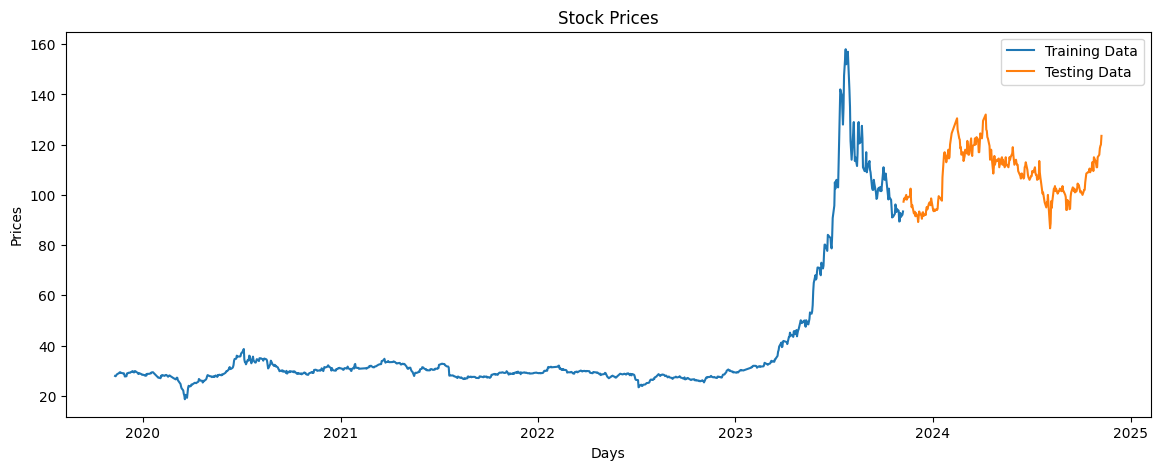

In [3]:
# 取得收盤價
close_prices = stock_data[['Close']]

# 資料集拆分
train_size = int(len(close_prices) * 0.8)
train_data = close_prices[:train_size]
test_data = close_prices[train_size:]

# 顯示訓練集和測試集的收盤價曲線
plt.figure(figsize=(14, 5))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data')
plt.title('Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [4]:
# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# 設置輸入窗口
window_size = 10

def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [5]:
!apt-get install ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ninja-build is already the newest version (1.10.1-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [17]:
from xlstm import xLSTMBlockStack, xLSTMBlockStackConfig, mLSTMBlockConfig, sLSTMBlockConfig, mLSTMLayerConfig, sLSTMLayerConfig
import torch
import torch.nn as nn

# 設置 mLSTM 和 sLSTM 區塊的配置
mlstm_config = mLSTMBlockConfig()  # 可以進一步自訂此配置
slstm_config = sLSTMBlockConfig()  # 可以進一步自訂此配置

# 設定 xLSTMBlockStackConfig
config = xLSTMBlockStackConfig(
    mlstm_block=mlstm_config,
    slstm_block=slstm_config,
    context_length=2000,          # 例如，設定輸入的序列長度為 20 天
    num_blocks=3,               # 設置 3 個區塊
    embedding_dim=64,           # 設定嵌入維度為 64
    add_post_blocks_norm=True,
    dropout=0.5
)


class StockPredictor(nn.Module):
    def __init__(self, input_size=1):
        super(StockPredictor, self).__init__()
        self.input_layer = nn.Linear(input_size, 64)  # 新增此層來調整輸入維度
        self.xlstm = xLSTMBlockStack(config)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.input_layer(x)        # 將輸入調整為 (batch_size, time_steps, 6)
        out = self.xlstm(x)            # 傳遞到 xLSTMBlockStack
        out = out[:, -1, :]            # 取最後一個時間步的輸出，形狀為 (batch_size, 6)
        out = self.output_layer(out)   # 使用線性層將輸出縮減為 1
        return out


# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 1  # 因為我們的輸入維度只有一個特徵
model = StockPredictor(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).to(device)

In [18]:
# 訓練模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_torch)
    loss = criterion(outputs.squeeze(), y_train_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 評估模型
model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).cpu().numpy()
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

Epoch [5/50], Loss: 0.0794
Epoch [10/50], Loss: 0.0351
Epoch [15/50], Loss: 0.0175
Epoch [20/50], Loss: 0.0120
Epoch [25/50], Loss: 0.0084
Epoch [30/50], Loss: 0.0066
Epoch [35/50], Loss: 0.0048
Epoch [40/50], Loss: 0.0034
Epoch [45/50], Loss: 0.0029
Epoch [50/50], Loss: 0.0022


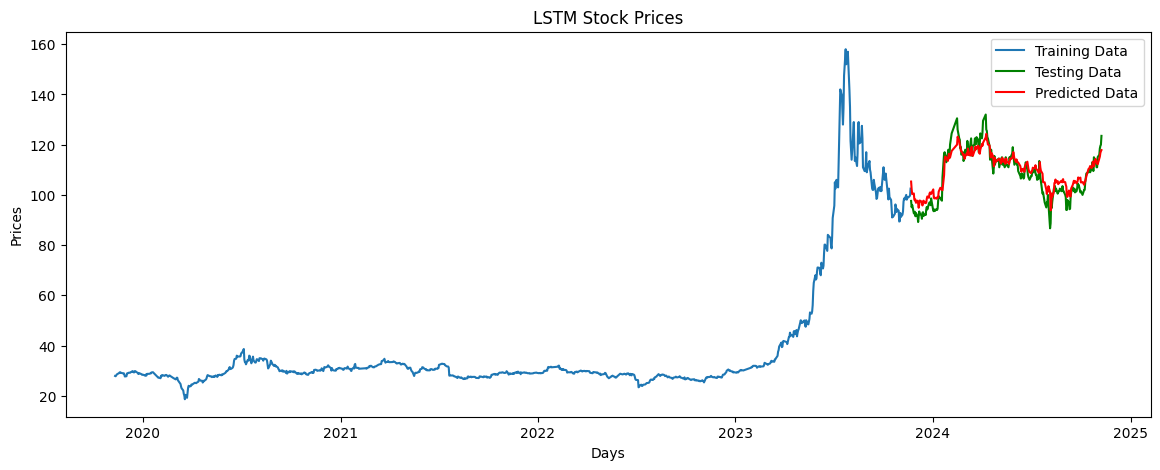

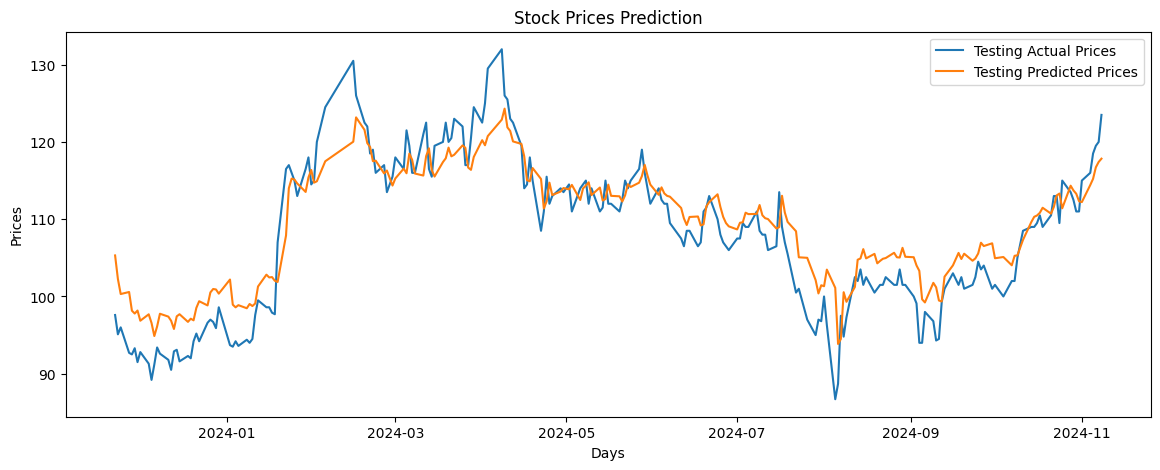

In [19]:
# 評估模型
model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).cpu().numpy()
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# 預測值轉為 DataFrame 格式
test_predict = pd.DataFrame(y_pred, columns=['Predicted'], index=test_data[window_size:].index)

# 繪製整個資料集
plt.figure(figsize=(14, 5))
plt.plot(close_prices[:train_size + window_size], label='Training Data')
plt.plot(close_prices[train_size + window_size:], label='Testing Data', color='green')
plt.plot(test_predict, label='Predicted Data', color='red')
plt.title('LSTM Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

# 繪製測試集部分
plt.figure(figsize=(14, 5))
plt.plot(close_prices[train_size + window_size:], label='Testing Actual Prices')
plt.plot(test_predict, label='Testing Predicted Prices')
plt.title('Stock Prices Prediction')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Transformer

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

[*********************100%***********************]  1 of 1 completed


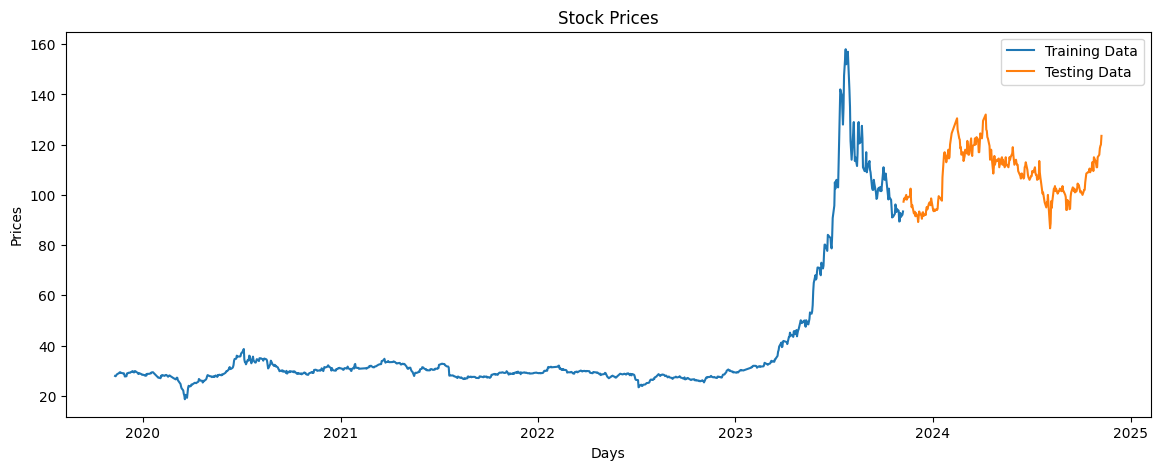

In [2]:
# 輸入股票代號
stock_id = "3231.TW"  # 緯創

# 5年的資料
start = dt.datetime(2019, 11, 11)
end = dt.datetime(2024, 11, 11)
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)

# 取得收盤價
close_prices = stock_data[['Close']]

# 資料集拆分
train_size = int(len(close_prices) * 0.8)
train_data = close_prices[:train_size]
test_data = close_prices[train_size:]

# 顯示訓練集和測試集的收盤價曲線
plt.figure(figsize=(14, 5))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data')
plt.title('Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [3]:
# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# 設置輸入窗口
window_size = 20

def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

# 為 Transformer 調整形狀 (batch, sequence_length, feature_dimension)
X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

In [4]:
# 定義 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()

        # 將輸入特徵的維度轉換為 Transformer 的模型維度
        self.fc1 = nn.Linear(input_dim, d_model)

        # 定義 Transformer 模型，包含編碼和解碼層
        self.transformer = nn.Transformer(
            d_model=d_model,          # Transformer 的模型維度
            nhead=nhead,              # 多頭注意力機制中的頭數
            num_encoder_layers=num_layers,  # 編碼器層的數量
            num_decoder_layers=num_layers,  # 解碼器層的數量
            dim_feedforward=dim_feedforward,  # Feedforward 層的維度
            dropout=dropout           # Dropout 比率，防止過擬合
        )

        # 定義輸出的全連接層，將 Transformer 的輸出轉換為所需的維度
        self.fc2 = nn.Linear(d_model, output_dim)

        # 初始化 src_mask 以應對自回歸性序列
        self.src_mask = None

    def forward(self, src):
        # 通過全連接層 fc1 將輸入資料嵌入至模型維度
        src = self.fc1(src)

        # 調整資料形狀以適應 Transformer，調整為 (sequence_length, batch_size, embedding_dim)
        src = src.permute(1, 0, 2)

        # 若沒有 src_mask 或 mask 大小不匹配，則生成 mask
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        # 傳遞到 Transformer 中，並應用 mask
        output = self.transformer(src, src, src_mask=self.src_mask)

        # 調整回 (batch_size, sequence_length, d_model) 並選擇最後一個時間步的輸出
        output = output.permute(1, 0, 2)

        # 通過全連接層 fc2，將 Transformer 的輸出轉換為預測的股價
        output = self.fc2(output[:, -1, :])
        return output

# 設置模型參數
input_dim = 1          # 輸入特徵維度
d_model = 64          # Transformer 的模型維度
nhead = 2              # 多頭注意力的頭數
num_layers = 1        # 編碼層和解碼層的數量
output_dim = 1         # 輸出特徵維度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 初始化模型、損失函數和優化器
model = TransformerModel(input_dim, d_model, nhead, num_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
# 將數據轉換為 tensor 格式
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).to(device)

In [6]:
# 訓練模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # 前向傳遞
    outputs = model(X_train_torch).squeeze()

    # 計算損失
    loss = criterion(outputs, y_train_torch)

    # 反向傳遞和優化
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [5/50], Loss: 0.5888
Epoch [10/50], Loss: 0.1493
Epoch [15/50], Loss: 0.0258
Epoch [20/50], Loss: 0.0633
Epoch [25/50], Loss: 0.0302
Epoch [30/50], Loss: 0.0206
Epoch [35/50], Loss: 0.0203
Epoch [40/50], Loss: 0.0111
Epoch [45/50], Loss: 0.0096
Epoch [50/50], Loss: 0.0122


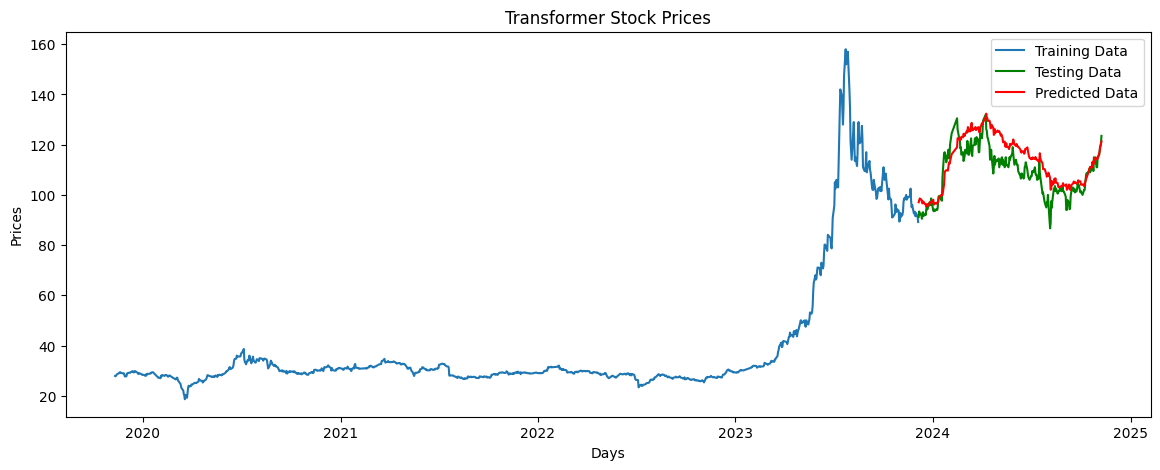

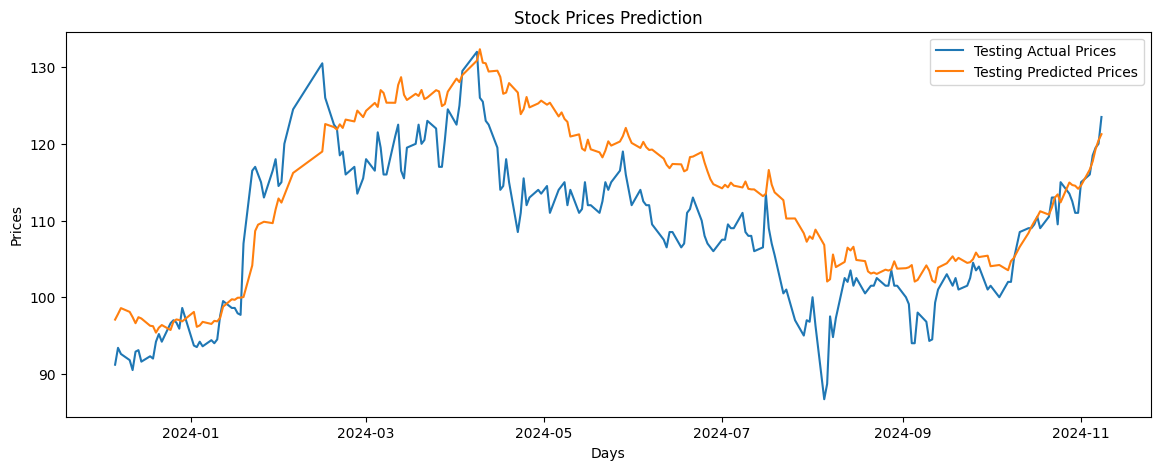

In [7]:
# 評估模型
model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).cpu().numpy()

# 反正規化預測值
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# 繪製結果
test_predict = pd.DataFrame(y_pred, columns=['Predicted'], index=test_data[window_size:].index)

plt.figure(figsize=(14, 5))
plt.plot(close_prices[:train_size + window_size], label='Training Data')
plt.plot(close_prices[train_size + window_size:], label='Testing Data', color='green')
plt.plot(test_predict, label='Predicted Data', color='red')
plt.title('Transformer Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

# 繪製測試集部分
plt.figure(figsize=(14, 5))
plt.plot(close_prices[train_size + window_size:], label='Testing Actual Prices')
plt.plot(test_predict, label='Testing Predicted Prices')
plt.title('Stock Prices Prediction')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()